# Predicting Successful Workers
### Using models to find what makes the best employees

### 1. Exploring the Data
 First we will read in the code using Python 2.7 and Pandas

In [23]:
# Import libraries
import numpy as np
import pandas as pd
from textblob import TextBlob
from sklearn import cross_validation as cv

In [24]:
# Read in the worker data

xls_file = pd.ExcelFile("Origami_Data.xlsx")
worker_data = xls_file.parse('Client Information')
print "worker data read successfully!"

comments = worker_data["Comments from the employer"]    

comments_list = comments.tolist()

neww = []
for comment in comments_list:
    if type(comment) is float:
        neww.append("TTTT")
    if type(comment) is unicode:
        neww.append(comment)


scores = []
for comment in neww:
    testimonial = TextBlob(comment)
    scores.append(testimonial.sentiment.polarity * testimonial.sentiment.subjectivity)
worker_data["Sentiment"] = scores

worker data read successfully!


Now let's to some basic exploratory analysis:

In [25]:
n_workers  = np.shape(worker_data)[0]
n_features = np.shape(worker_data)[1]
n_passed = np.shape(worker_data[worker_data['Placement Successful']=='Y'])[0]
n_failed = np.shape(worker_data[worker_data['Placement Successful']=='N'])[0]
success_rate = float(n_passed) / float(n_workers)*100
print "Total number of placements: {}".format(n_workers)
print "Number of workers who succeeded: {}".format(n_passed)
print "Number of workers who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Successful placements after 6 months: {:.2f}%".format(success_rate)

Total number of placements: 199
Number of workers who succeeded: 123
Number of workers who failed: 76
Number of features: 10
Successful placements after 6 months: 61.81%


### 2. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

#### Clean up values
First make sure to clean up non-consistent data in columns state and gender


In [36]:
# Make all state data shorthand and include gender only with M or F
worker_data['State'] = map(lambda x: x.lower(), worker_data['State'])
worker_data = worker_data.replace({'alabama':'al','florida':'fl','georgia':'ga','south carolina':'sc','louisiana':'la'}, regex=True)
states = ['al','fl','ga','la','sc']
worker_data = worker_data.loc[worker_data['State'].isin(states)]
gender = ['M','F']
worker_data = worker_data.loc[worker_data['Gender'].isin(gender)]

# Remove NaN
worker_data2 = worker_data.dropna(axis = 0, how = 'any', subset = ['Sentiment','Employed In Past 6 Months','Gender','Age','State','Education Level'])


#### Identify feature and target columns

Now let's separate our data into feature and target columns, and see which features are non-numeric.<br/>
**Note**: For this dataset, the column (`'Placement Successful'`) is the target feature

In [54]:
# Extract feature (X) and target (y) columns, and removing ID and Comments columns
feature_cols = ['Employed In Past 6 Months','Gender','Age','State','Education Level','OFFICE/MANUAL']
target_col = ['Placement Successful']

x_all = worker_data2[feature_cols]
y_all = worker_data2[target_col]

np.shape(x_all)

(187, 6)

#### Preprocess feature columns

It turns out there are a few non-numeric columns that need to be converted! One of them is simply `yes`/`no`, e.g. `'Employed In Past 6 Months'`. This can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `State` and `Education Level`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `AL`, `GA`, `FL`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are called _dummy variables_, and so we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to create these columns.

In [55]:
# Convert the target feature Y/N -Placement Successful- to 1/0
y_all = y_all.replace({'Y':1, 'N':0})

def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'state' => 'state_AL', 'state_GA'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

x_all = preprocess_features(x_all)

print "Processed feature columns ({}):-\n{}".format(len(x_all.columns), list(x_all.columns))

Processed feature columns (16):-
[u'Employed In Past 6 Months', u'Gender_F', u'Gender_M', u'Age', u'State_al', u'State_fl', u'State_ga', u'State_la', u'State_sc', u'Education Level_College Dropout ', u'Education Level_College Graduate', u'Education Level_High School Drop Out', u'Education Level_High School Graduate', u'Education Level_Technical School', u'OFFICE/MANUAL_MANUAL', u'OFFICE/MANUAL_OFFICE']


In [56]:
y_all = y_all['Placement Successful']



### 3. Training and Evaluating Models

#### Running multiple trials and finding the mean accuracy of classifier

As the dataset is relatively small and the results can vary from run to run. We will average 50 trials to find the most likely probability to our future predictions, assuming we do not overfit too much.

In [57]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 
all_scores = []

for x in range(50):
    x_all_train, x_all_test, y_all_train, y_all_test = cv.train_test_split(x_all, y_all, test_size=.3)
    clf = RandomForestClassifier(n_estimators = 30)
    clf = clf.fit(x_all_train,y_all_train.values.ravel())
    all_scores.append(clf.score(x_all_test, y_all_test.values))

print "The average score for this classifier over 50 trials is {:.2%}".format(np.mean(all_scores))

The average score for this classifier over 50 trials is 80.25%


#### Most important features

With the plot below it appears that age and employment status of the past 6 months are both important indicators of future success.

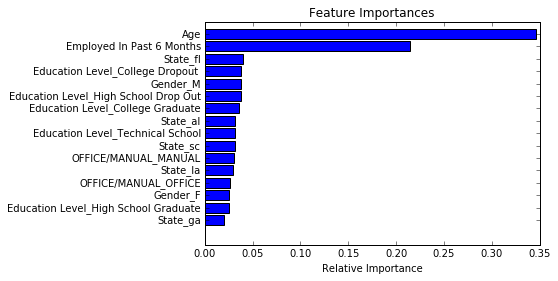

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

clf = RandomForestClassifier(n_estimators = 50)
clf = clf.fit(x_all_train,y_all_train.values.ravel())
clf.score(x_all_test, y_all_test.values)

importances = clf.feature_importances_
features = x_all_train.columns
indices = np.argsort(importances)
 
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])

plt.xlabel('Relative Importance')
plt.show()

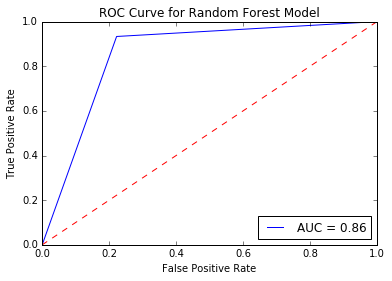

In [59]:
from sklearn.metrics import roc_curve, auc

clf = clf.fit(x_all_train,y_all_train.values.ravel())
preds = clf.predict(x_all_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_all_test.values.ravel(),preds)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('ROC Curve for Random Forest Model')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
print "The false positive rate is {:.2%}".format(false_positive_rate[1])
print "The true positive rate is {:.2%}".format(true_positive_rate[1])


The false positive rate is 22.22%
The true positive rate is 93.33%


## The model had an average prediction accuracy of 80%, with an AUC of 0.86. The false positive rate is 22.22% and the true positive rate is 93.33%